In [429]:
import sys
import os
import glob
from skimage import io
from matplotlib import pyplot as plt
from skimage.transform import resize, rotate
from skimage.measure import find_contours, approximate_polygon, regionprops, label
from skimage.color import label2rgb
from skimage.draw import circle_perimeter, rectangle_perimeter
from skimage.util import invert
from skimage import color
from skimage.morphology import closing, opening, disk

In [254]:
# do wersji v1
import math 
import numpy as np
def get_line_lenght(point1, point2):
    return math.pow((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 , 0.5)
def get_angle_of_line(line):
    (point1, point2) = line
    return math.atan2(point2[1] - point1[1], point2[0] - point1[0]) * 180 / np.pi

def get_angle_to_rotate_image(image):
    thresh = threshold_otsu(image)
    image = image > thresh
    edges = canny(image, sigma=1, low_threshold=False, high_threshold=True)
    min_length = image.shape[0] if image.shape[0] >= image.shape[1] else image.shape[1]
    lines = probabilistic_hough_line(edges, threshold=10, line_length=int(min_length/2),
                                     line_gap=10)

    longest_line = (lines[0],  get_line_lenght(lines[0][0], lines[0][1]))
    for line in lines:
        temp_lenght = get_line_lenght(line[0], line[1])
        if temp_lenght > longest_line[1]:
            longest_line = (line, temp_lenght)

    angle = get_angle_of_line(longest_line[0])
    return angle

In [255]:
# do wersji v2
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny


def compare_2_numbers_with_range(n1, n2, range=3):
    difference = abs(n1-n2)
    return difference <= range
compare_2_numbers_with_range(5.40, 3.10, 3)

def compare_2_points_with_range(point1, point2, range=3):
    x1, y1 = point1
    x2, y2 = point2
    return compare_2_numbers_with_range(x1, x2, range) and compare_2_numbers_with_range(y1, y2, range)
compare_2_points_with_range((10,20), (8,27), 5)

def check_if_perpendicular_lines(line1, line2):
    point11, point12 = line1
    point21, point22 = line2
    if compare_2_points_with_range(point11, point21, 10) or compare_2_points_with_range(point11, point22, 10) or compare_2_points_with_range(point12, point21, 10):     
        angle_between_lines = abs(get_angle_of_line(line1)-get_angle_of_line(line2))
        if compare_2_numbers_with_range(angle_between_lines, 90, 5):
            return True
    
    return False

def get_base_line(img):
    thresh = threshold_otsu(image)
    image = image > thresh
    edges = canny(image, sigma=1, low_threshold=False, high_threshold=True)
    min_length = image.shape[0] if image.shape[0] >= image.shape[1] else image.shape[1]
    lines = probabilistic_hough_line(edges, threshold=10, line_length=int(min_length/2),
                                     line_gap=10)
    
    for line1 in lines:
        counter = 0
        for line2 in lines:
            if check_if_perpendicular_lines(line1, line2):
                counter += 1
        if counter >= 2:
            return line1
    
    return None



In [417]:
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
def clear_images(images):
    images_cleared = list()
    for img in images:
        thresh = threshold_otsu(img)
        bw = closing(img > thresh, square(3))
        cleared = clear_border(bw)
        images_cleared.append(cleared)
    return images_cleared

def rotate_images(images):
    images_rotated = list()
    for img in images:
        angle = get_angle_to_rotate_image(img)
        img = rotate(img, angle).astype(np.uint8)
        images_rotated.append(img)
    return images_rotated

def resize_images(images):  
    max_height, max_width = images[0].shape
    for image in images:
        if image.shape[0] > max_height:
            max_height = image.shape[0]
        if image.shape[1] > max_width:
            max_width = image.shape[1]
#     shape = (longest_height, longest_width)
#     images_resized = [(resize(img, shape)*255).astype(np.uint8) for img in images]
    
    images_resized = list()
    for image in images:
        scale = max_width/image.shape[1]
        new_shape = (int(image.shape[0]*scale), int(image.shape[1]*scale))
        resized_image = (resize(image, new_shape)*255).astype(np.uint8)
        images_resized.append(resized_image)
    
    return images_resized

def cut_images_sides(images):
    images_rect = list()
    images_cut = list()
    for img in images:
#         thresh = threshold_otsu(img)
#         bw = closing(img > thresh, square(3))
#         img = clear_border(bw)
        
        label_img, num = label(img, connectivity=2, return_num=True, background=0)
        region_props = regionprops(label_img)
#         print(num)
#         print(region_props[0].bbox)
        biggest_region = region_props[0]
        for region in region_props:
            if region.area > biggest_region.area:
                biggest_region = region

#         x,y = rectangle_perimeter((1,biggest_region.bbox[1]), (img.shape[0]-2,biggest_region.bbox[3]))
#         x,y = rectangle_perimeter((biggest_region.bbox[0], biggest_region.bbox[1]), (biggest_region.bbox[2], biggest_region.bbox[3]))
#         img = color.grey2rgb(img)
#         img[x,y] = [255,0,0]
#         images_rect.append(img)
#         images_cut.append(img[:,biggest_region.bbox[1]:biggest_region.bbox[3]+1])
        images_cut.append(img[biggest_region.bbox[0]:biggest_region.bbox[2],biggest_region.bbox[1]:biggest_region.bbox[3]+1])

        
    return images_cut

In [418]:
# wersja używa najdłuższej linii w figurze jako podstawy
def rotate_scale_and_cut_v1(images_paths):
    images = [io.imread(path) for path in images_paths]
    images = rotate_images(images)
    images = cut_images_sides(images)
    
    images = resize_images(images)
#     print("po rot: ", images[5][70])
    return images

# wersja szuka linii, które mają kąt prosty jako podstawa, chyba mniejsze zaufanie mam do tego
def rotate_and_scale_v2(images_paths):
    images_rotated = list()
    for image_path in images_paths:
        img = io.imread(image_path)
        base_line = get_base_line(img)
        angle = get_angle_of_line(base_line)
        img = rotate(img, angle)
        images_rotated.append(img)
        
    shape = images_rotated[0].shape
    images_resized = [resize(img, shape) for img in images_rotated]
    return images_resized

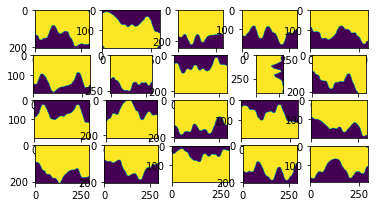

In [435]:
n_of_cases = 5
path = os.path.join('D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1', '')
images_paths = glob.glob(os.path.join(path, '*.png'))

images = rotate_scale_and_cut_v1(images_paths)
images = [img*255 for img in images]
images = [closing(opening(img, disk(10)), disk(10)) for img in images]
fig = plt.figure()
columns = 5
rows = (len(images_paths)/columns)+1
for i, img in enumerate(images):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)


(193, 294)


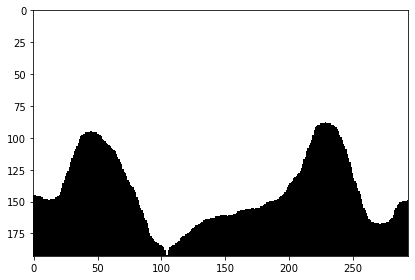

In [441]:
print(images[5].shape)
io.imshow(images[5])

(200, 294)


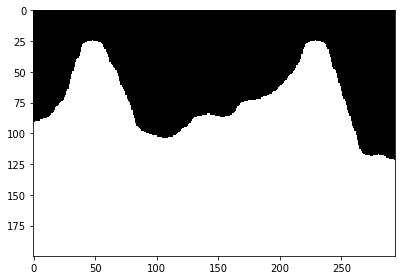

In [437]:
print(images[10].shape)
io.imshow(images[10])

In [ ]:
images = [io.imread(path) for path in images_paths]
imgs = cut_images_sides(images)
fig = plt.figure()
columns = 5
rows = (len(images_paths)/columns)+1
for i, img in enumerate(imgs):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    


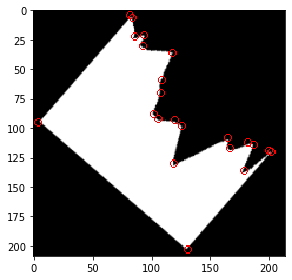

In [59]:
img = io.imread(images_paths[0])
contours = find_contours(img, level=3)
img = color.grey2rgb(img)
for n, contour in enumerate(contours):
    appr_pol = approximate_polygon(contour, tolerance=2)
    for c in appr_pol:
        x,y = circle_perimeter(int(c[0]),int(c[1]), 3)
        img[x,y] = [255,0,0]
        
io.imshow(img)

In [ ]:
# skalowanie według najdłuzszej linii

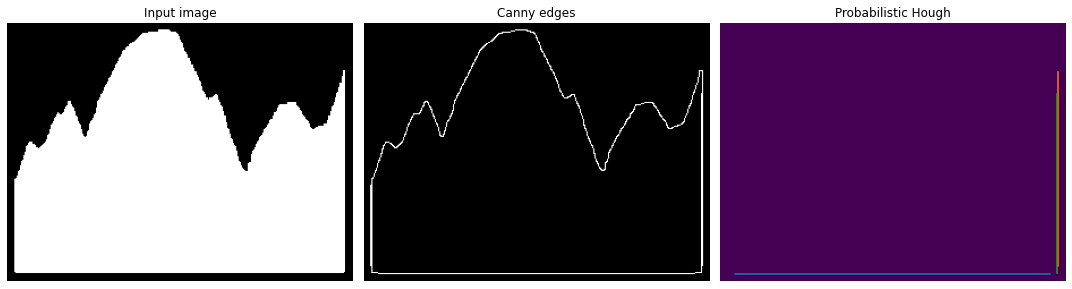

In [320]:
import numpy as np

from skimage.morphology import closing, opening
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm


# Line finding using the Probabilistic Hough Transform
image = io.imread(images_paths[11])
thresh = threshold_otsu(image)
image = image > thresh

# image = closing(image, square(5))
# image = opening(image, square(5))

edges = canny(image, sigma=1, low_threshold=False, high_threshold=True)
min_length = cleared.shape[0] if cleared.shape[0] >= cleared.shape[1] else cleared.shape[1]
lines = probabilistic_hough_line(edges, threshold=10, line_length=int(min_length/2),
                                 line_gap=5)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()